This tutorial reproduces the results of tutorial 13 from spinw.org. It is the spin wave spectrum of LiNiPO4. The parameters were obtained from "T. Jensen, et al., PRB 79, 6 (2009) http://arxiv.org/abs/0902.2288 " or or "http://prb.aps.org/abstract/PRB/v79/i9/e092413" 

Get Packages

In [1]:
using Sunny,GLMakie, CairoMakie

Define the lattice. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. The space group is Pnma or 62. Note that a specific setting needs to be provided for Sunny to correctly recognize the system. The supercell is (1,2,2)

In [2]:
a=10.02
b=5.86
c=4.68

latvecs = lattice_vectors(a, b, c, 90, 90, 90)
positions=[[1/4, 1/4, 0]]
Ni = Crystal(latvecs,positions,62,setting="");
GLMakie.activate!()
view_crystal(Ni,6)
print_symmetry_table(Ni,8)
sys=System(Ni, (1,2,2),[SpinInfo(1,S=3/2,g=2)], :dipole, seed=0)

┌ Warning: view_crystal(cryst, max_dist) will soon be removed! Use `view_crystal(cryst)` instead. See also optional `ghost_radius` argument.
└ @ PlottingExt /Users/bhushanthipe/.julia/packages/Sunny/Kmqzx/ext/PlottingExt.jl:579


Atom 1
Position [1/4, 1/4, 0], multiplicity 4
Allowed g-tensor: [  A 0 D-E
                     0 B   0
                   D+E 0   C]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,0] + c₂*𝒪[2,1] + c₃*𝒪[2,2] +
    c₄*𝒪[4,0] + c₅*𝒪[4,1] + c₆*𝒪[4,2] + c₇*𝒪[4,3] + c₈*𝒪[4,4] +
    c₉*𝒪[6,0] + c₁₀*𝒪[6,1] + c₁₁*𝒪[6,2] + c₁₂*𝒪[6,3] + c₁₃*𝒪[6,4] + c₁₄*𝒪[6,5] + c₁₅*𝒪[6,6]

Bond(2, 3, [0, 0, 0])
Distance 3.7497333238512, coordination 4
Connects [3/4, 3/4, 0] to [3/4, 1/4, 1/2]
Allowed exchange matrix: [  A F+I E-H
                          F-I   B D+G
                          E+H D-G   C]
Allowed DM vector: [G H I]

Bond(1, 1, [0, 0, -1])
Distance 4.68, coordination 2
Connects [1/4, 1/4, 0] to [1/4, 1/4, -1]
Allowed exchange matrix: [  A 0 D-E
                            0 B   0
                          D+E 0   C]
Allowed DM vector: [0 E 0]

Bond(4, 2, [0, 0, 0])
Distance 5.5295298172629, coordination 2
Connects [1/4, 3/4, 1/2] to [3/4, 3/4, 0]
Allowed exchange matrix: [  A 0 D-E
        

System [Dipole mode]
Lattice (1×2×2)×4
Energy per site 0


Set up the exchanges. Note that the given anisotropy values in the paper are incorrect. Correct values obtained from the thesis of T. Jensen have been used. Randomize the spins and minimize the energy to obtain the ground state of the system.

In [3]:
Jbc =  1.036;
Jb  =  0.6701;
Jc  = -0.0469;
Jac = -0.1121;
Jab =  0.2977;
Da  =  0.1969;
Db  =  0.9097;
Dc  =  0;

set_exchange!(sys,Jbc,Bond(2, 3, [0, 0, 0]))
set_exchange!(sys,Jc,Bond(1, 1, [0, 0, -1]))
set_exchange!(sys,Jb,Bond(1, 1, [0, 1, 0]))
set_exchange!(sys,Jab,Bond(1, 2, [0, 0, 0]))
set_exchange!(sys,Jab,Bond(3, 4, [0, 0, 0]))
set_exchange!(sys,Jac,Bond(3, 1, [0, 0, 0]))
set_exchange!(sys,Jac,Bond(4, 2, [0, 0, 0]))
S=spin_operators(sys,1)
set_onsite_coupling!(sys,Da*S[1]^2+Db*S[2]^2,1)
randomize_spins!(sys)
minimize_energy!(sys)
plot_spins(sys)
energy(sys)

┌ Warning: `spin_operators` will soon be removed! Use `spin_matrices(spin_label(sys, i))` instead.
└ @ Sunny /Users/bhushanthipe/.julia/packages/Sunny/Kmqzx/src/deprecated.jl:10


-68.38320000000006

Set up an array of paths and perform LSWT calculations alons these paths. Plot the dispersionl convoluted spectra and spin-spin correlations for these paths.

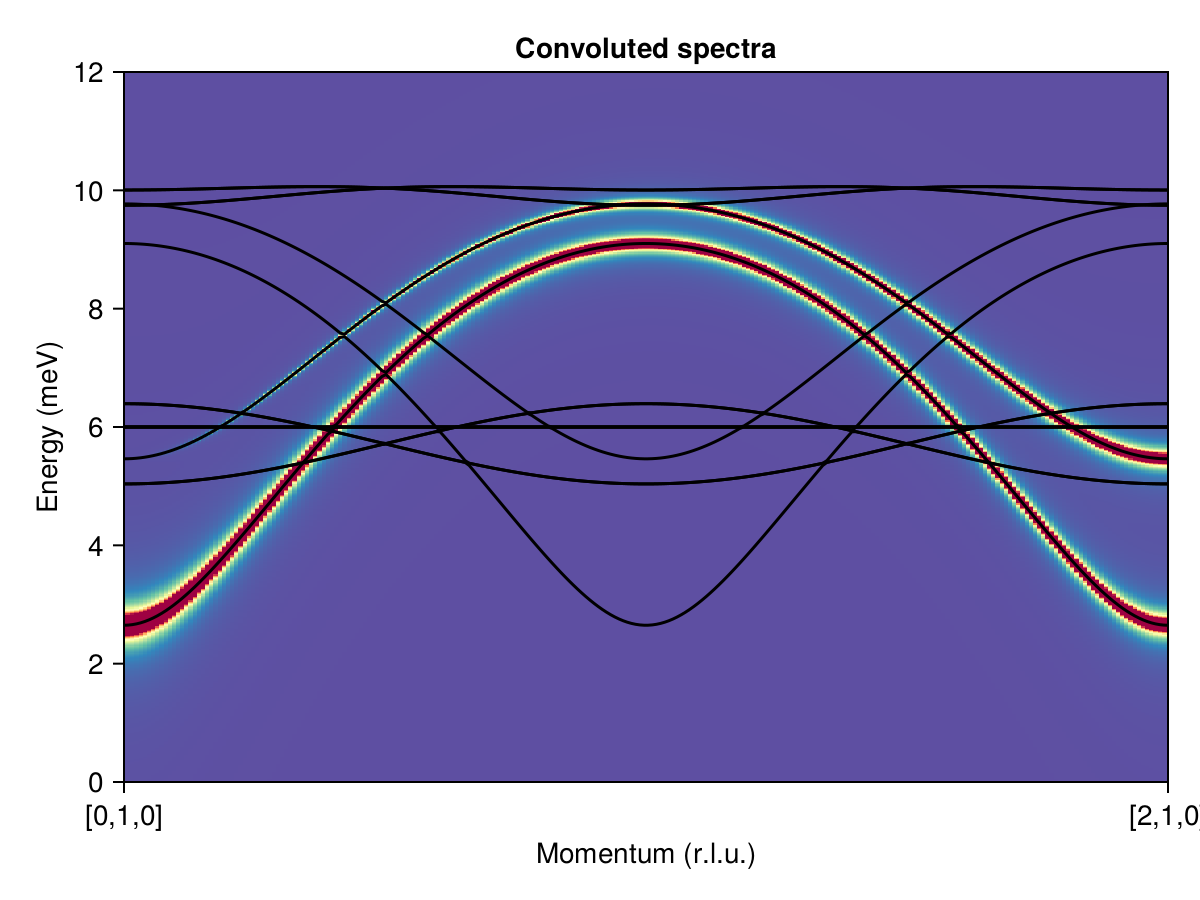

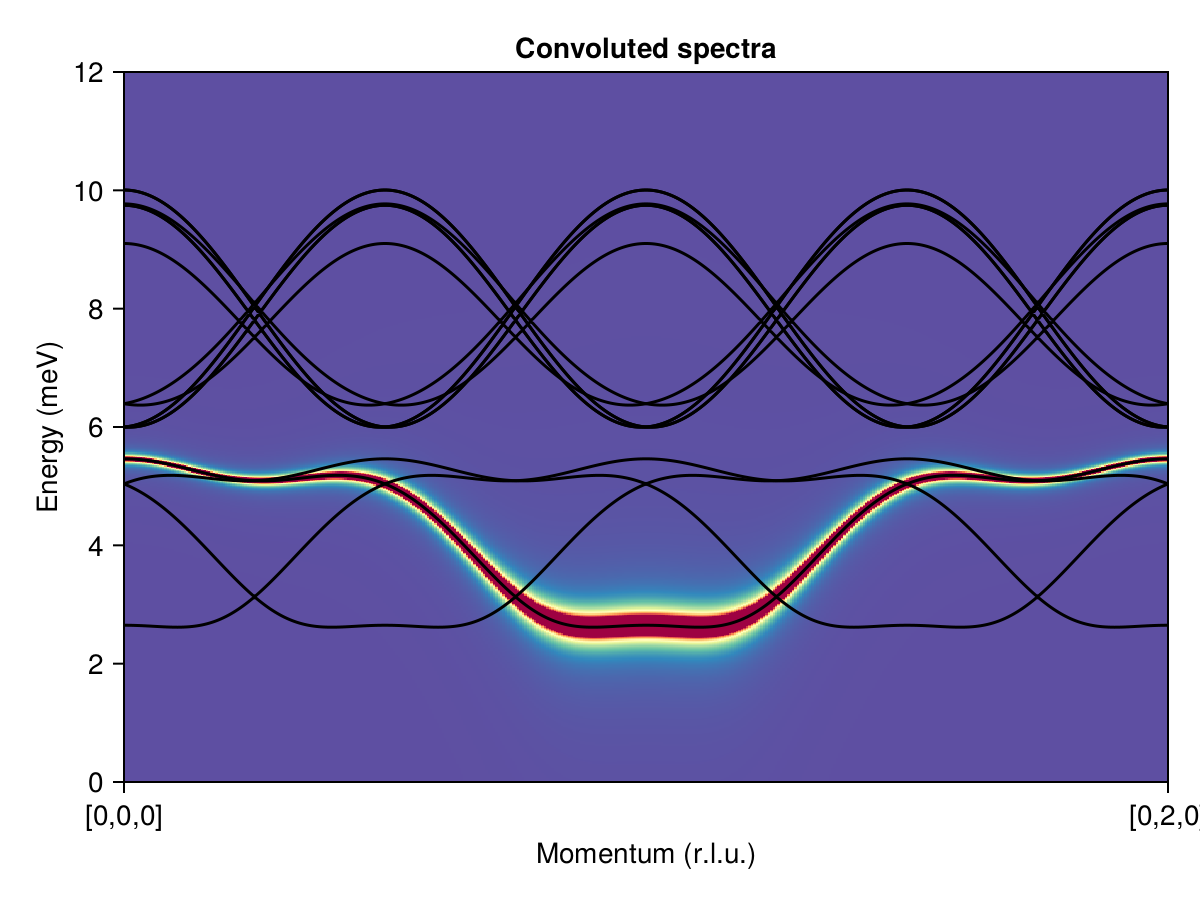

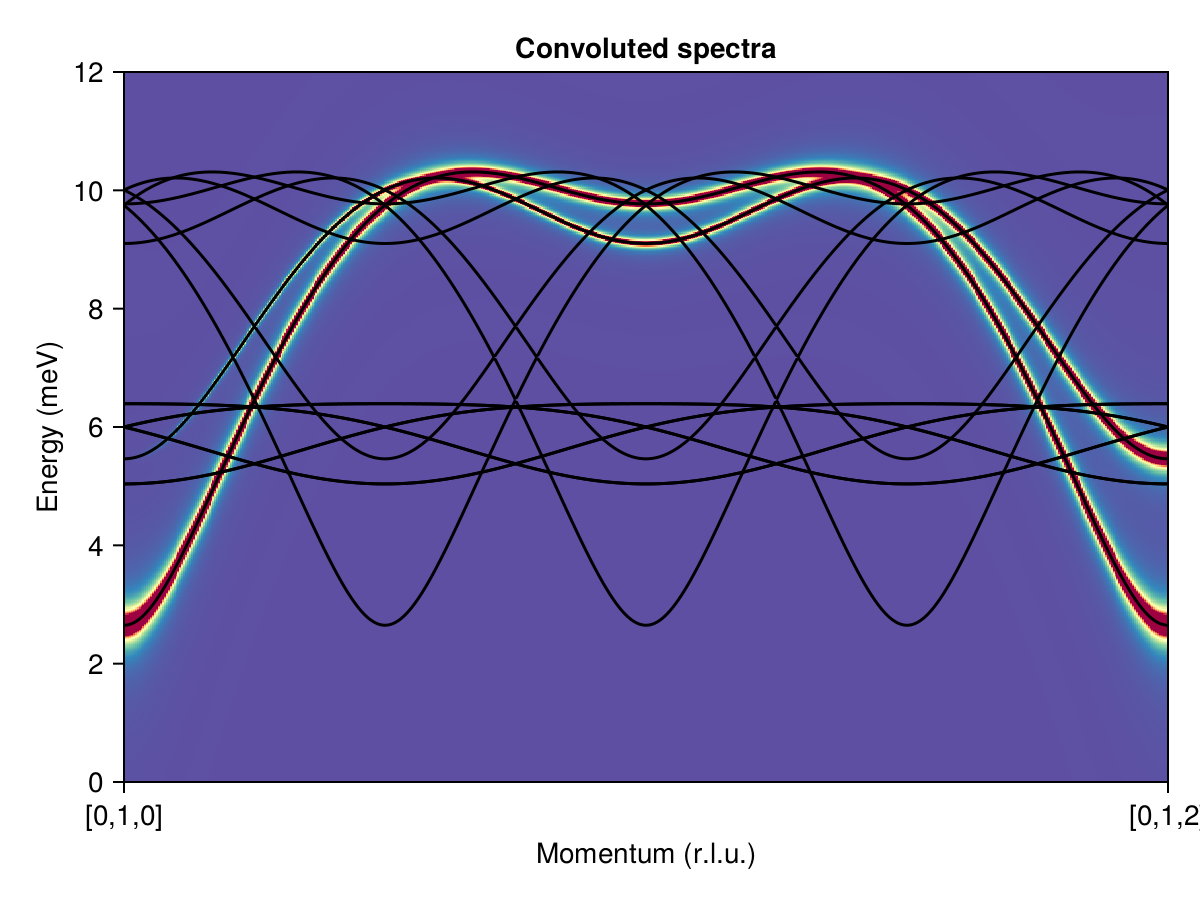

In [4]:
q_points=[[[0,1,0],[2,1,0]],[[0,0,0],[0,2,0]],[[0,1,0],[0,1,2]]]
for i in 1:length(q_points)
    density = 200
    path, xticks = reciprocal_space_path(Ni, q_points[i], density);
    swt=SpinWaveTheory(sys)
    formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
    disp, intensity = intensities_bands(swt, path, formula);

    CairoMakie.activate!()
    fig = Figure()
    ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", title="Convoluted spectra",xticks)
    ylims!(ax, 0.0, 12)
    xlims!(ax, 1, size(disp, 1))
    fig
    γ = 0.02 # width in meV
    broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))

    energies = collect(0:0.02:12)  # 0 < ω < 10 (meV).
    is = intensities_broadened(swt, path, energies, broadened_formula);
    fig
    pl=heatmap!(ax, 1:size(is, 1), energies, is,colorrange=(0,1))
    pl.colormap = Reverse(:Spectral)
    
    colorrange = extrema(intensity)
    for i in axes(disp)[2]
        lines!(ax, 1:length(disp[:,i]), disp[:,i]; color="black",colorrange)
    end
    display(fig)

   
end